## I - Problem Statement

- **Given** - A Data Set of Fake and Real news.

- **Objective** - To develop a solution which  
  detects if a given news is Fake or Real.

- **Methodology used** - We try to pose the  problem as a text classification problem and build a deep learning model for achieving the objective.

#### Different Models 
While there multiple types of models which could be used for building the solution for Text Classification. Some Examples are - 


*   **1D- Conv Net** - 
Yes, CNNs could also be used for text.<br/>
  **Advantage**: They are faster to train. In fact given proper label, a CNN model could achieve decent accuracy.<br/> 
  **Disdvantage**: They fail to capture long term dependencies in Text, and doesnt not capture sequential information in text.

*   **RNN based models (LSTM, GRU)** -  
  **Advantage** : They focus on considering words T each time step, encoding them by some non-linear calculation and then taking a decision. In simple words, they can capture sequential nature of a Text. <br/>
  **Disadvantage** - Slower to train, focus is more on sequential nature, and less on attention mechanism.

* **Transformer based Models(BERT, GPT2)** - 
Transformer based models are a breaktrhough in NLP, and tend to model. Which leverages multiple Transformer units, and a multi-headed attention mechanism. The advantage is that they focus only on attention mechanism. Thus we obtain a model, which is can used in context heavy applications.




## II - StandAlone BERT Model -  

- For our solution we will be using BERT model to develop Fake News or Real News Classification Solution. 

- We achieved an accuracy of 95+ % on test set, and a remarkable AUC by a standalone BERT Model. More improvements could be done with better tuning, and training for longer time. In cloud settings like Google Cloud(with larger GPUs) or AWS infra. But improvement is a continuous process :)

- We build an MVP with BERT Stand-alone model

- We can Also use, BERT (as an embedder) + LSTM model to build this solution. 

![BERT Classfier](https://miro.medium.com/max/876/0*ViwaI3Vvbnd-CJSQ.png)

Above figure shows the Kind of model we will be building in developing our solution.




## III - Coding Environment  

- I chose Google Colab for two reasons primarily - Firstly, To Document the process step by step. Secondly, other than this I wanted to leverage the free GPU available in Google Colab. 

- The avaialble GPU helped me train faster, compared to my own PC.(well, you might notice that even the the resource, got exhausted after 2 epochs, but we created a checkpoint to save the model)


- In production as well, GPU powered AWS    frameweorks such as AWS Sagemaker and Google GPU cloud infra are useful in training models and deploying quicker. 

- For coding environment we can develop models
  using Keras or Tensorflow. Depending upon    
  the level of control we want on model 
  creation, we can work with that TF versions and utilities such as core, and functional APIs. 

- For more control and inner workings of     
  model, TF core comes is usually very useful, 
  and for quicker prototyping we can go for  
  Keras or  TF2.0 which is keras style.

- I chose to go with Tensorflow 2.0 for BERT TF.2.0 model for classification.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IV - Data Preprocessing and Exploration




### Loading Data

Our data are json files stored on web, therefore we download it and convert it into pandas dataframe

In [ ]:
import urllib
import json

def load_convert_data(url):
    """
    Downloads the json file from net and convert into pandas dataframe format.
    """
    with urllib.request.urlopen(url) as url:
        df = json.loads(url.read().decode())
        df = pd.DataFrame.from_dict(df)
        
    return df

Given:

There are 4 files:
- training - set of real news. 
- testing - set of real news.
- training - set of fake news.
- testing - set of fake news

In [ ]:
# Real news data
real_train = load_convert_data("https://storage.googleapis.com/public-resources/dataset/real_train.json")
real_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/real_test.json")

In [ ]:
len(real_train)

800

In [ ]:
len(real_test)

200

In [ ]:
# Fake news data
fake_train = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_train.json")
fake_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")

In [ ]:
len(fake_train)

800

In [ ]:
len(fake_test)

200

In [ ]:
# quick look on real news training data
real_train.head()

,url,title,text
0,https://www.thetimes.co.uk/edition/scotland/sc...,Scots GPs told not to meet fever patients as f...,Scots GPs told not to meet fever patients as f...
1,https://www.bbc.com/news/world-africa-52103799,Coronavirus : Fighting al - Shabab propaganda ...,Coronavirus: Fighting al-Shabab propaganda in ...
2,https://www.thetimes.co.uk/edition/business/en...,Engineer fears China virus impact,Engineer fears China virus impact\nA British e...
3,https://www.theguardian.com/world/live/2020/fe...,Coronavirus : South Korean PM vows swift act...,Here’s a summary of what’s happened so far on ...
4,https://yle.fi/uutiset/osasto/news/finnair_iss...,Finnair issues profit warning over Covid - 19 ...,Finnair issues profit warning over Covid-19 fe...


**Observation** : -

- We can see that there are 800 rows and 3 columns for real news in training set, we will only use the 'text' column for modeling (for simplicity sake). 

- In case if the model doesnt perform well, we can use multiple features like url as well.

- However, we acheived good performance by using text data alone.

In [ ]:
# Quick look on Fake news training data
fake_train.head()

,url,title,text
0,https://nabd.com/s/71539812-b7228b/%D9%86%D8%B...,Online Facts New conspiracy theory: #Bel_Gates...,Roger Stone suggested on Monday that Bill Gate...
1,https://shamra.sy/news/article/8eb73454931e6d1...,Revolutionary Guards: Corona could be an Ameri...,Source\nRussia Today |\nIranian Revolutionary ...
2,https://sudanewsnow.com/19800/,Yellow skin is the host environment of the vir...,Sudan news now from all sources sudanewsnow.co...
3,https://arabic.rt.com/press/1100276-%D8%A7%D9%...,China and Russia are doing what the European U...,China and Russia are doing what the European U...
4,https://www.kachaf.com/details.php?n=5e8957fe1...,,Fatal error: Uncaught MongoDB\Driver\Exception...


**Observations** :- 
- Training set of Fake news contain also 800 rows.
- So we can see that the number of real news and fake news are same in our dataset.

- It won't be an imbalanced classification problem.

### General Data Preprocessing

Next we label our data where real news are labeled as 0 (negative) and fake news are labeled as 1 (positive). The reason we label fake news as positive is that the main purpose of the modeling is to detect fake news.

In [ ]:
real_train['label'] = 0
real_test['label'] = 0
fake_train['label'] = 1
fake_test['label'] = 1

train = pd.concat([real_train, fake_train], ignore_index=True)
test = pd.concat([real_test, fake_test], ignore_index=True)

We then remove non alphanumeric characters as well as converting to all lower case from the text.

In [ ]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

train['text'] = train['text'].apply(clean_txt)
test['text'] = test['text'].apply(clean_txt)

### Plotting Data

#### Word Count histogram

We use train set to perform exploratory analysis. First we want to look at the word count for each news and see if there is difference between real and fake news.





/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


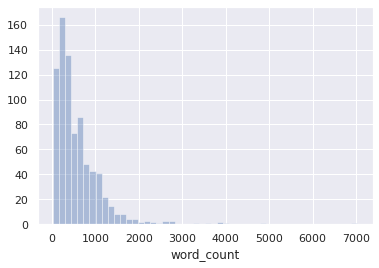

In [ ]:
train['word_count'] = [len(s.split()) for s in train['text']]
#real 
sns.distplot(train['word_count'][train['label'] == 0], kde=False, rug=False)

We can see from the above graph that most real news are within 1000 words, and the distribution of word count is skewed to the right.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


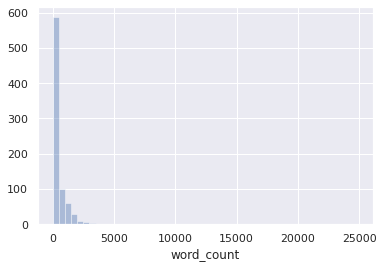

In [ ]:
#fake 
sns.distplot(train['word_count'][train['label'] == 1], kde=False, rug=False)

As for the fake news, we see some outliers from above figure, making it hard to intepret, so we plot it again below with outlier (news that has more than 20,000 words) removed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


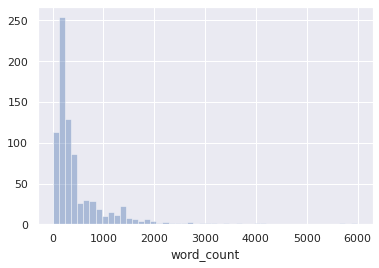

In [ ]:
sns.distplot(train['word_count'][(train['label'] == 1) & (train['word_count'] < 20000)], kde=False, rug=False)

We can see the word count distribution of fake news are more skewed, most of the news have words below 500. 

#### Word Cloud

Next we like to see what are the most common words in real/fake news to discover some patterns. Word cloud is a popular way to visualize it.

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(target,width = 800, height = 400):
    """
    Plot wordcloud of real/fake news
    
    target: real/fake
    width: the width of plotted figure
    height: the height of plotted figure
    """
    if target == 'real':
        t = 0
    elif target == 'fake':
        t = 1
    text = ''
    for t in train['text'][train['label'] == t]:
        text = text + t
    wordcloud = WordCloud(max_font_size=40, min_font_size=20, width=800, height = 400, random_state=0).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

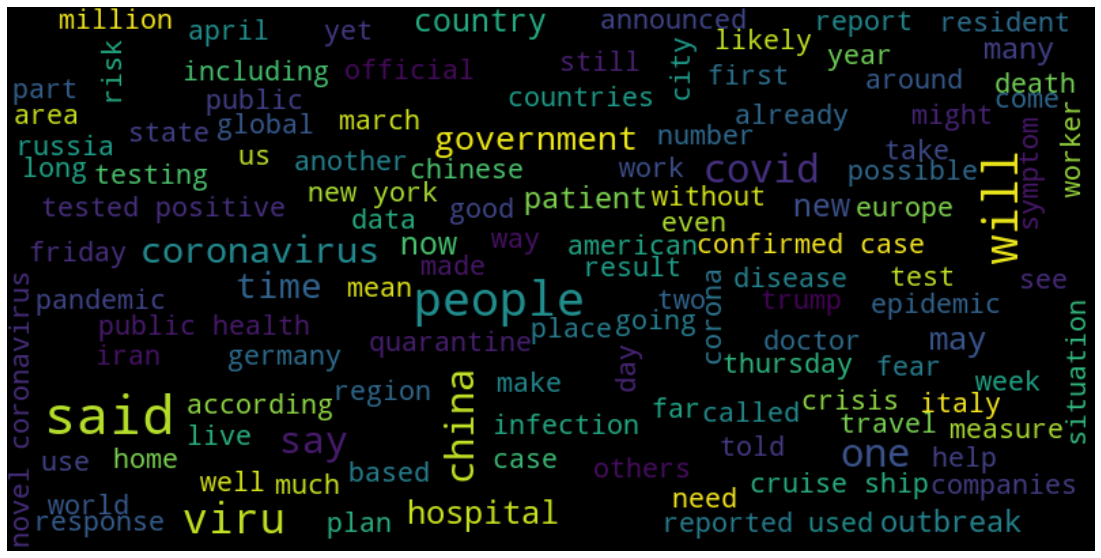

In [ ]:
plot_wordcloud('real',width = 800, height = 400)

We can see most of the real news are about COVID19 virus, and the common words are countries name and some neutural words.

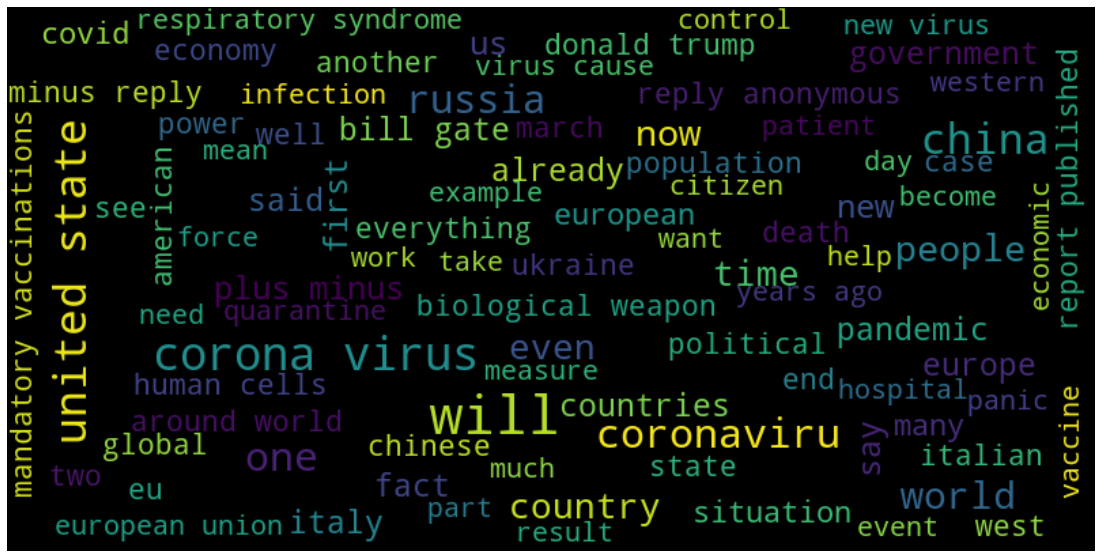

In [ ]:
plot_wordcloud('fake',width = 800, height = 400)

As for fake news, the topic is also the same. However, it contain some strong words such as biological weapon, as well as some names such as Donald Trump and Bill Gates.

#### TopK Word Proportion

Next we would like to see the topk word proportion of the real/fake news. In other words, we like to see how many of the words used in the news are from the top 10 common words, top 100, and so on. The reason to do so is that we suppose fake news are machine generated and it use many high frequency words comparing to real news.

In [ ]:
# how many words in top 10, top 100, and top 1000
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def concat_text(target):
    """
    Concat the news into one large document and split it into a list.
    """
    if target == 'real':
        t = 0
    elif target == 'fake':
        t = 1
        
    text = ''
    for t in train['text'][train['label'] == t]:
        text = text + t
    text = text.split(' ')

    return text

def most_frequent_words(text):
      """
      Calculate and order the vocab by its frequency.
      """
      ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
      X = ngram_vectorizer.fit_transform(text)
      vocab = np.array(list(ngram_vectorizer.get_feature_names()))
      counts = np.array(X.sum(axis=0).A1)
      inds = counts.argsort()[::-1]
      ordered_vocab = vocab[inds]

      return ordered_vocab


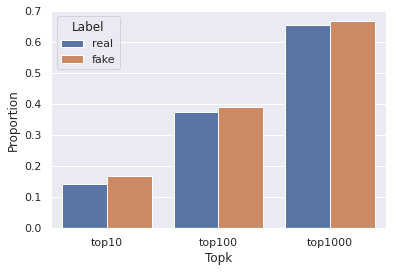

In [ ]:
def plot_topK_distribution(k1 = 10, k2 = 100, k3 = 1000):
    """
    Plot the comparison bar chart between real and fake news.

    k1: most common k1 words
    k2: most common k2 words
    k3: most common k3 words
    """
    real_text = concat_text('real')
    fake_text = concat_text('fake')

    real_vocab = most_frequent_words(real_text)
    fake_vocab = most_frequent_words(fake_text)
    
    x = ['top' + str(k1), 'top' + str(k2), 'top' + str(k3)] 
    label = ['real','real','real','fake','fake','fake']
    y = [np.mean([s in real_vocab[1:k1] for s in real_text]),
         np.mean([s in real_vocab[1:k2] for s in real_text]),
         np.mean([s in real_vocab[1:k3] for s in real_text]),
         np.mean([s in fake_vocab[1:k1] for s in fake_text]),
         np.mean([s in fake_vocab[1:k2] for s in fake_text]),
         np.mean([s in fake_vocab[1:k3] for s in fake_text])]

    df = pd.DataFrame(zip(x*2, label, y), columns=["Topk", "Label", "Proportion"])
    sns.barplot(x="Topk", hue="Label", y="Proportion", data=df)
    plt.show()

plot_topK_distribution(k1 = 10, k2 = 100, k3 = 1000)

However, we see that fake news are slightly more often to have top frequent words, but the difference is not significant.

# V -  Modeling
For this project, we use BERT as our modeling algorithm.

### Splitting Data to Train/Validation

First we like to split our training set into training and validation set with a ratio of 8:2, this way we can use the validation to tune our model, and finally predict on the hold out test set.

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)

### Long Document Preprocessing

Since BERT algorithm can only accept sentence length up to 512 words, we need to preprocess our data (long news) in order to feed in to the algorithm. To do so, we follow the idea from [this paper](https://arxiv.org/abs/1910.10781) and segment each of the text into multiple subtext of no longer than 150 words. The subtexts will have some overlapping, specifically, the last 30 words for first subtext will be the first 30 words of the second subtext. 

In [ ]:
def get_split(text):
    """
    Split each news text to subtexts no longer than 150 words.
    """
    l_total = []
    l_parcial = []
    if len(text.split())//120 >0:
        n = len(text.split())//120
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:150]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*120:w*120 + 150]
            l_total.append(" ".join(l_parcial))
    return l_total

train['text_split'] = train['text'].apply(get_split)
val['text_split'] = val['text'].apply(get_split)
test['text_split'] = test['text'].apply(get_split)

In [ ]:
train['text_split'][1]

['coronavirus fighting al shabab propaganda in somalia muslim clerics in conflict hit somalia are moving to the front line of the battle against coronavirus in a bid to counter the propaganda of militant islamists writes bbc somalia analyst mary harper the al qaeda linked al shabab group has warned muslims to beware of infectious diseases such as coronavirus which it says are spread by the crusader forces who have invaded the country and the disbelieving countries that support them the militants control much of southern and central somalia and have been a powerful force for well over a decade although there have only been a handful of confirmed cases of coronavirus in somalia so far the authorities are deeply worried that if the disease takes hold they will be unable to cope koranic schools shut about 30 years of conflict have devastated health facilities hundreds of thousands of displaced people',
 'that if the disease takes hold they will be unable to cope koranic schools shut about 

As we can see from above example, a piece of long document is splitted into list of multiple subtexts. Next, we augument our original data into a larger dataset where each row contains a piece of subtext and its corresponding label and index.

In [ ]:
def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['text_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'text':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' texts.')
    return new_df

train_df = data_augumentation(train, df_name = 'training')
val_df = data_augumentation(val, df_name  = 'validation')
test_df = data_augumentation(test, df_name = 'testing')

The training set now has 5621 subtexts extracted from 1280 texts.
The validation set now has 1305 subtexts extracted from 320 texts.
The testing set now has 1568 subtexts extracted from 400 texts.


### Building BERT Model

In [ ]:
!pip install bert-for-tf2
import math 
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

First we like to load the pretrained weight of BERT and finetune it. The source of pretrained weights is called uncased_L-12_H-768_A-12. Since Because tf.train.load_checkpoint limitation requiring list permissions on the google storage bucket, we perform a tweak below to copy the pre-trained BERT weights locally.

In [ ]:
%%time

bert_ckpt_dir="gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/"
bert_ckpt_file = bert_ckpt_dir + "bert_model.ckpt"
bert_config_file = bert_ckpt_dir + "bert_config.json"

bert_model_dir="2018_10_18"
bert_model_name="uncased_L-12_H-768_A-12"

!mkdir -p .model .model/$bert_model_name

for fname in ["bert_config.json", "vocab.txt", "bert_model.ckpt.meta", "bert_model.ckpt.index", "bert_model.ckpt.data-00000-of-00001"]:
  cmd = f"gsutil cp gs://bert_models/{bert_model_dir}/{bert_model_name}/{fname} .model/{bert_model_name}"
  !$cmd

!ls -la .model .model/$bert_model_name

bert_ckpt_dir = os.path.join(".model/",bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_config.json...
/ [1 files][  313.0 B/  313.0 B]                                                
Operation completed over 1 objects/313.0 B.                                      
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/vocab.txt...
/ [1 files][226.1 KiB/226.1 KiB]                                                
Operation completed over 1 objects/226.1 KiB.                                    
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.meta...
/ [1 files][883.0 KiB/883.0 KiB]                                                
Operation completed over 1 objects/883.0 KiB.                                    
Copying gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/bert_model.ckpt.index...
/ [1 files][  8.3 KiB/  8.3 KiB]                                                
Operation completed over 1 objects/8.3 KiB.                                      
Copying gs://bert_models/2

Next we preprocess our original text into input features BERT can read. The process is basically tokenizing and coverting our original text into token ids that can be read by the algorithm. The words are tokenized base on the vocabulary dictionary it pretrained on(about 30,000 words), and unknown words are breaken down into smaller words contained in the dictionary. Maximum sequence length are also specified so we can pad all sequence into the same length. 
Note: The final sequence length would be larger than specified since BERT tokenizer will break unknown words into multiple small known words.

In [ ]:
class FakeNewsData:
    """
    Preprocessing text into BERT features.

    max_seq_len: Maximum sequence length specified
    tokenizer: BERT tokenizer
    """
    DATA_COLUMN = "text"
    LABEL_COLUMN = "label"

    def __init__(self, tokenizer, train, validation, test, max_seq_len = 150):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        ((self.train_x, self.train_y),
         (self.val_x, self.val_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, validation, test])

        ((self.train_x, self.train_x_token_types),
         (self.val_x, self.val_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        """
        Add start and end token for each sequence, and convert the text to tokenids.
        """
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[FakeNewsData.DATA_COLUMN], row[FakeNewsData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        """
        Pad each sequence to the specified max sequence length with [0]
        """
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)

In [ ]:
%%time
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
data = FakeNewsData(tokenizer, 
                    train = train_df,
                    validation = val_df,
                    test = test_df,
                    max_seq_len= 150)

100%|██████████| 5.62k/5.62k [00:19<00:00, 291it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 1.30k/1.30k [00:04<00:00, 292it/s]
100%|██████████| 1.57k/1.57k [00:05<00:00, 294it/s]


CPU times: user 29.2 s, sys: 277 ms, total: 29.5 s
Wall time: 29.9 s


In [ ]:
def create_model(max_seq_len,lr = 1e-5):
  """
  Creates a BERT classification model. 
  The model architecutre is raw input -> BERT input -> drop out layer to prevent overfitting -> dense layer that outputs predicted probability.

  max_seq_len: the maximum sequence length
  lr: learning rate of optimizer
  """


  # create the bert layer
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  output = bert(input_ids)

  print("bert shape", output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
  # Dropout layer
  cls_out = keras.layers.Dropout(0.8)(cls_out)
  # Dense layer with probibility output
  logits = keras.layers.Dense(units=2, activation="softmax")(cls_out)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  # load the pre-trained model weights
  load_stock_weights(bert, bert_ckpt_file)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  model.summary()
        
  return model

model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)

bert shape (None, 319, 768)
Done loading 196 BERT weights from: .model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9dd495cb90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 319)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 319, 768)        

### Model Training

In [ ]:
import datetime
OUTPUT_DIR = '/bert_news'
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

log_dir = ".log/bert_news/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

def model_fitting(max_epoch = 5, patience = 1):
    """
    Function to fit the model to training set. Validation set are used to find the optimal training epochs.
    Model will stop training when validation accuracy don't improve for a number of epochs. Then the model will restore weights to its best validation performance.

    max_epoch: Maximum number of epochs to train
    patience: Number of non-improving epochs before model stops
    """
  
    model.fit(x=data.train_x, y=data.train_y,
              validation_data = (data.val_x,data.val_y),
              batch_size=16,
              shuffle=True,
              epochs=max_epoch,
              callbacks=[keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
                        tensorboard_callback])
    return model

model = model_fitting(max_epoch = 5, patience = 1)
# Save the optimal weights for future usage
model.save_weights('bert_news.h5', overwrite=True)

***** Model output directory: /bert_news *****
Epoch 1/5
352/352 [==============================] - 543s 2s/step - loss: 0.5591 - acc: 0.7315 - val_loss: 0.3903 - val_acc: 0.9188
Epoch 2/5
352/352 [==============================] - 544s 2s/step - loss: 0.4074 - acc: 0.9018 - val_loss: 0.3747 - val_acc: 0.9349
Epoch 3/5
352/352 [==============================] - 539s 2s/step - loss: 0.3818 - acc: 0.9295 - val_loss: 0.3578 - val_acc: 0.9540
Epoch 4/5
352/352 [==============================] - 541s 2s/step - loss: 0.3611 - acc: 0.9516 - val_loss: 0.3638 - val_acc: 0.9487


In [ ]:
# Download the model checkpoint 
# OPTIONAL STEP - if we want to use them for prediction somewhere
from google.colab import files
files.download('bert_news.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Evaluation

After model is done training, we evaluate on training set, validation set, and test set. The metric used is accuracy.

In [ ]:
%%time 
# model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)
model.load_weights("bert_news.h5")

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, val_acc = model.evaluate(data.val_x, data.val_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc: ", train_acc)
print("validation acc: ", val_acc)
print("test acc: ", test_acc)

49/49 [==============================] - 22s 406ms/step - loss: 0.1195 - acc: 0.9554
train acc:  0.9889699220657349
validation acc:  0.961685836315155
test acc:  0.9553571343421936
CPU times: user 31.9 s, sys: 12.6 s, total: 44.5 s
Wall time: 1min 55s


**Evaluation Observations**:

We can see that we have about ~ aapprox 96.0 % accuracy for training set and about 95.40 % accuracy for our validation set. 
This seems to be good, however, there are two more things we should do. 

1. The prediction is on the **augumented** test set, but we care more about the prediction on **original** text. Therefore, for each original text, we should average the probabily of each subtexts and obtain final prediction for that piece of news.

2. Other metrics such as AUC to get a more thorough evaluation of our model.

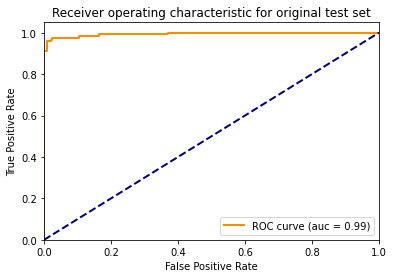

Orignal test accuracy is  0.975
Orignal test auc is  0.9945999999999999
Orignal test precision is  0.975
Orignal test recall is  0.975
Orignal test f1 score is  0.975


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
# model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)
model.load_weights("bert_news.h5")

# predict on test set
predictions = model.predict(data.test_x)
predictions = predictions[:,1]
test_df['pred'] = predictions
# average the prediction to become final prediction of original test set
test['avg_pred'] = test_df.groupby(['index'])['pred'].mean()

# plot ROC curve
fpr, tpr, _ = roc_curve(test['label'], test['avg_pred'])
roc_auc = auc(fpr, tpr)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for original test set')
plt.legend(loc="lower right")
plt.show()

acc = accuracy_score(test['label'], test['avg_pred'] > 0.5)
precision = precision_score(test['label'], test['avg_pred'] > 0.5)
recall = recall_score(test['label'], test['avg_pred'] > 0.5)
f1 = f1_score(test['label'], test['avg_pred']  > 0.5)

print('Orignal test accuracy is ', acc)
print('Orignal test auc is ', roc_auc)
print('Orignal test precision is ', precision)
print('Orignal test recall is ', recall)
print('Orignal test f1 score is ', f1)

# VI - Predicting on a New Text- "NEWS"
The goal of building model is to predict new coming instances. Below is a function to load the model checkpoint and predict result of input document. Please run everything before Model Training section in the notebook.


HOW TO PREDICT ?- 

I - via SAVED MODEL (If you dont want to train model again)

- If you wish to predict from the already saved model, 
- Please keep the model ('bert.h5') in mounted google drive 
- Replace the path of the mounted model in SAVED_MODEL variable value in the below code snippet.

II - New Trained Model (If you ran all code blocks)
 - If you have again run all the code blocks.
 - Please simply replace the SAVED_MODEL value with 'bert.h5'
 - Because after training the model will be saved with that name in current path.



In [ ]:
# As per the steps above :)

SAVED_MODEL_PATH  = "bert_news.h5"

In [ ]:
# create model and load previous weights
model = create_model(max_seq_len = data.max_seq_len)
model.load_weights(SAVED_MODEL_PATH)


bert shape (None, 319, 768)
Done loading 196 BERT weights from: .model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa7ac6e0358> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 319)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 319, 768)      

In [ ]:
def predict_new(doc, model):
    """
    Predict new document using the trained model. 

    doc: input document in format of a string
    """

    # clean the text
    doc = clean_txt(doc)
    # split the string text into list of subtexts
    doc = get_split(doc)
    # tokenize the subtexts as well as padding 
    tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
    pred_tokens = map(tokenizer.tokenize, doc)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))
    
    # create model and load previous weights
    # model = create_model(max_seq_len = data.max_seq_len)
    # model.load_weights()

    # predict the subtexts and average the prediction
    predictions = model.predict(pred_token_ids)
    predictions = predictions[:,1]
    avg_pred = predictions.mean()
    if avg_pred > 0.5:
      doc_label = 'fake'
    else:
      doc_label = 'Real'

    return doc_label, avg_pred



In [ ]:
# Run an example text from original test set
fake_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")
doc = fake_test['text'][7]
print('----------------------NEWS -----------------------')
print(doc)
doc_label, avg_pred = predict_new(doc, model)
print()
print('---------------- PREDICTION RESULTS --------------')
print('The predicted probability of news being FAKE is ', avg_pred)
print('CLASSIFICATION : The predicted label of news is ', doc_label.upper())

----------------------NEWS -----------------------
Elena Malysheva, the famous Russian presenter and presenter, has shed some nutrients that can boost the body's immunity to fight infection with the Corona virus.
World - Europe
During one of her televised medical programs, Malysheva said: "Food products that contain large amounts of zinc are necessary to activate the so-called killer cells in the body. These cells, according to doctor Andre Prodius, are tasked with killing other cells infected with the virus."
The doctor indicated that a person can get this important component from different foods such as shellfish, oats and corn flakes.
According to Malysheva, the elderly with diabetes are among the most at risk of corona, due to the symptoms that may cause zinc deficiency in their bodies, which may affect the work of their immune system.
The doctor advised those suffering from cardiovascular diseases and cancer patients to add the Brazilian nuts to their diet as it contains selenium,